In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.metrics import fbeta_score, make_scorer

In [16]:
# ------------------------------
# 1. Data Splitting (Assuming dataset is already clean)
# ------------------------------
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.drop(columns=['EmployeeCount', 'StandardHours', 'EmployeeNumber'], inplace=True)
df.drop_duplicates(inplace=True)

# Convert Attrition to binary: 'Yes' → 1, 'No' → 0.
df["Attrition"] = df["Attrition"].map({'Yes': 1, 'No': 0})

X = df.drop("Attrition", axis=1)
y = df["Attrition"]

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# Reset indices to ensure alignment
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

In [17]:
# ------------------------------
# 2. Define Column Groups & Preprocessing Options
# ------------------------------
# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Columns to keep as ordinal (already integers)
ordinal_cols = ['Education', 'EnvironmentSatisfaction', 'JobInvolvement',
                'JobLevel', 'JobSatisfaction', 'PerformanceRating',
                'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']

# For numeric columns, we want to apply log transform only on those that are not ordinal.
numeric_to_transform = [col for col in numeric_cols if col not in ordinal_cols]

# For categorical columns, separate BusinessTravel so we can experiment with its encoding.
business_travel = ['BusinessTravel']
other_cat_cols = [col for col in categorical_cols if col not in business_travel]

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, mapping=None):
        # Default mapping if none is provided.
        if mapping is None:
            mapping = {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
        self.mapping = mapping
        
    def fit(self, X, y=None):
        # Optionally, you could store the unique categories here.
        # For now, simply mark the encoder as fitted.
        self.fitted_ = True
        return self
    
    def transform(self, X):
        # Ensure the transformer has been fitted.
        if not hasattr(self, 'fitted_'):
            raise ValueError("This CustomOrdinalEncoder instance is not fitted yet. Call 'fit' before using this method.")
        
        # If X is a numpy array and has shape (n_samples, 1), flatten it.
        if isinstance(X, np.ndarray):
            if X.ndim == 2 and X.shape[1] == 1:
                s = pd.Series(X.ravel())
                mapped = s.map(self.mapping)
                if mapped.isnull().any():
                    raise ValueError("Some values were not found in the mapping")
                return mapped.values.reshape(-1, 1)
            else:
                raise ValueError("Expected a 2D array with a single column")
        else:
            # If X is a pandas DataFrame or Series.
            if isinstance(X, pd.DataFrame):
                if X.shape[1] == 1:
                    s = X.iloc[:, 0]
                    mapped = s.map(self.mapping)
                    if mapped.isnull().any():
                        raise ValueError("Some values were not found in the mapping")
                    return mapped.values.reshape(-1, 1)
                else:
                    # If there are multiple columns, apply mapping on each.
                    return X.apply(lambda col: col.map(self.mapping)).values
            elif isinstance(X, pd.Series):
                mapped = X.map(self.mapping)
                if mapped.isnull().any():
                    raise ValueError("Some values were not found in the mapping")
                return mapped.values.reshape(-1, 1)
            else:
                raise ValueError("Input type not recognized. Expected numpy array or pandas DataFrame/Series.")


In [24]:
# ------------------------------
# 3. Build Preprocessing Pipelines
# ------------------------------
# Numeric pipeline: we allow toggling log transform.
# The 'log' step will be controlled via the parameter grid.
num_pipeline =  Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p, validate=True)),  # can be set to 'passthrough'
    ('scaler', StandardScaler())  # can switch to MinMaxScaler via grid
])
# We will apply the numeric pipeline only to numeric_to_transform columns.

# For ordinal columns, no transformation is needed.
ordinal_pipeline = 'passthrough'

# For BusinessTravel, we experiment with either one-hot encoding or ordinal encoding.
bus_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))  # parameter grid can swap in OrdinalEncoder()
])

# For other categorical features, use one-hot encoding.
other_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
])

# Build the overall preprocessor via ColumnTransformer.
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_to_transform),
    ('ord', ordinal_pipeline, ordinal_cols),
    ('bus', bus_pipeline, business_travel),
    ('other_cat', other_cat_pipeline, other_cat_cols)
])


In [25]:
# ------------------------------
# 4. Define Feature Selection Options
# ------------------------------
# Define three feature selection strategies.
feat_sel_rfe = RFE(estimator=LogisticRegression(max_iter=500, random_state=42), n_features_to_select=10)
feat_sel_lasso = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', random_state=42))
feat_sel_tree = SelectFromModel(RandomForestClassifier(random_state=42), threshold='median')


In [27]:
import copy
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone

# Define the base models with fixed (default) hyperparameters.
base_models = {
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'MLP': MLPClassifier(max_iter=500, random_state=42)
}

# Define a parameter grid that tunes only the pipeline steps.
pipeline_param_grid = {
    'preprocessor__num__log': [FunctionTransformer(np.log1p, validate=True), 'passthrough'],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
    'preprocessor__bus__encoder': [OneHotEncoder(drop='first'), CustomOrdinalEncoder()],
    'feat_sel': ['passthrough', feat_sel_rfe, feat_sel_lasso, feat_sel_tree]
}

# Dictionary to store the best pipeline for each base model (without classifier hyperparameter tuning)
best_pipeline_nonhyper = {}

# Loop over each base model
for model_name, model in base_models.items():
    print(f"\nTuning pipeline steps for {model_name}...")
    
    # Create a pipeline with the current base model and fixed classifier settings.
    pipeline_model = ImbPipeline([
        ('preprocessor', clone(preprocessor)),  # clone to avoid side-effects
        ('smote', SMOTE(random_state=42)),
        ('feat_sel', 'passthrough'),              # placeholder; will be tuned
        ('classifier', model)                     # fixed classifier for now
    ])
    
    # Perform grid search over only the pipeline steps.
    grid_search_model = GridSearchCV(
        pipeline_model,
        param_grid=pipeline_param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2
    )
    
    grid_search_model.fit(X_train, y_train)
    
    # Store the best pipeline for the current model.
    best_pipeline = grid_search_model.best_estimator_
    best_pipeline_nonhyper[model_name] = best_pipeline
    print(f"Best pipeline for {model_name}: {grid_search_model.best_params_}")



Tuning pipeline steps for LogisticRegression...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   0.0s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   0.1s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   0.1s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   0.1s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.8s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.3s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, prep

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.2s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.3s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.8s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.1s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   0.9s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.1s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.1s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.0s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.6s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEnc

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.4s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.4s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, ra

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.4s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.7s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.4s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.3s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.4s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.4s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passth

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.6s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.6s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.5s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0,

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.6s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.8s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.4s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Tr

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.4s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.6s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.5s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.0s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.4s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.3s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.8s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, 

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.1s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.4s
[CV] END 

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.9s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.9s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.9s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.9s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.2s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel':

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.6s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.8s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.8s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__enco

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.6s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.8s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
           

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.6s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.6s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.6s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.6s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.6s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.7s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.7s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.6s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.8s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.8s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.6s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.6s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.6s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransf

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.7s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.6s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncode

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.6s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.6s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(ma

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.7s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.7s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.7s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.6s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.4s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.4s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rare

In [29]:
from sklearn.model_selection import cross_validate

def display_cv_scores(pipeline_dict, X, y, cv=5):
    """
    Computes and prints the mean cross-validated ROC AUC and accuracy scores for each pipeline.
    
    Parameters:
    - pipeline_dict: dict
         Dictionary where keys are model names and values are the best pipeline (an estimator).
    - X: array-like, features.
    - y: array-like, labels.
    - cv: int, number of folds for cross-validation.
    """
    # Define the scoring metrics
    scoring = {'roc_auc': 'roc_auc', 'accuracy': 'accuracy'}
    
    for model_name, pipeline in pipeline_dict.items():
        # Evaluate both metrics via cross-validation
        scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        mean_roc_auc = scores['test_roc_auc'].mean()
        std_roc_auc = scores['test_roc_auc'].std()
        mean_accuracy = scores['test_accuracy'].mean()
        std_accuracy = scores['test_accuracy'].std()
        
        print(f"{model_name}:")
        print(f"  Mean CV ROC AUC = {mean_roc_auc:.4f} (Std: {std_roc_auc:.4f})")
        print(f"  Mean CV Accuracy = {mean_accuracy:.4f} (Std: {std_accuracy:.4f})")
        print("-" * 40)

# Example usage:
display_cv_scores(best_pipeline_nonhyper, X_train, y_train)


LogisticRegression:
  Mean CV ROC AUC = 0.8369 (Std: 0.0513)
  Mean CV Accuracy = 0.7866 (Std: 0.0350)
----------------------------------------
DecisionTree:
  Mean CV ROC AUC = 0.6502 (Std: 0.0524)
  Mean CV Accuracy = 0.8045 (Std: 0.0318)
----------------------------------------
RandomForest:
  Mean CV ROC AUC = 0.8138 (Std: 0.0522)
  Mean CV Accuracy = 0.8665 (Std: 0.0138)
----------------------------------------
GradientBoosting:
  Mean CV ROC AUC = 0.8058 (Std: 0.0602)
  Mean CV Accuracy = 0.8623 (Std: 0.0072)
----------------------------------------
MLP:
  Mean CV ROC AUC = 0.8031 (Std: 0.0555)
  Mean CV Accuracy = 0.8682 (Std: 0.0163)
----------------------------------------


In [30]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone

# Define the classifier hyperparameter grids for random search.
classifier_grids = {
    'LogisticRegression': {
         'classifier__C': [0.01, 0.1, 1, 10, 100],
         'classifier__penalty': [None,'l1', 'l2'],
         'classifier__solver': ['liblinear', 'saga']
    },
    'DecisionTree': {
         'classifier__max_depth': [None, 5, 10, 20],
         'classifier__min_samples_split': [2, 5, 10],
         'classifier__min_samples_leaf': [1, 2, 4],
         'classifier__criterion': ['gini', 'entropy']
    },
    'RandomForest': {
         'classifier__n_estimators': [100, 200, 300],
         'classifier__max_depth': [None, 5, 10, 20],
         'classifier__min_samples_split': [2, 5, 10],
         'classifier__min_samples_leaf': [1, 2, 4],
         'classifier__max_features': ['sqrt', 'log2', None]
    },
    'GradientBoosting': {
         'classifier__n_estimators': [100, 200, 300],
         'classifier__learning_rate': [0.01, 0.1, 1],
         'classifier__max_depth': [3, 5, 7, 10],
         'classifier__subsample': [0.8, 1.0],
         'classifier__max_features': ['sqrt', 'log2', None]
    },
    'MLP': {
         'classifier__hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
         'classifier__alpha': [0.0001, 0.001, 0.01],
         'classifier__learning_rate_init': [0.001, 0.01],
         'classifier__activation': ['relu', 'tanh']
    }
}

# Define your fixed base models (same as before)
base_models = {
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'MLP': MLPClassifier(max_iter=500, random_state=42)
}

# Dictionary to store the best pipeline for each classifier after random search tuning.
best_classifier_pipelines_random = {}
n_iter = 50  # Adjust this value depending on your computational budget.

# Loop over each classifier type.
for clf_name, clf_grid in classifier_grids.items():
    print(f"\nTuning classifier hyperparameters with random search: {clf_name}")
    
    # Create a new pipeline that uses the best preprocessing/feature selection configuration
    # from Step 1 (best_pipeline_nonhyper) and the fixed base model.
    # We use clone() to ensure we don't modify the original pipeline.
    pipeline_clf = ImbPipeline([
         ('preprocessor', clone(best_pipeline_nonhyper[clf_name].named_steps['preprocessor'])),
         ('smote', SMOTE(random_state=42)),
         ('feat_sel', best_pipeline_nonhyper[clf_name].named_steps['feat_sel']),
         ('classifier', base_models[clf_name])
    ])
    
    # Setup RandomizedSearchCV for the classifier hyperparameters.
    random_search = RandomizedSearchCV(
         pipeline_clf,
         param_distributions=clf_grid,
         n_iter=n_iter,
         cv=5,
         scoring='roc_auc',
         n_jobs=-1,
         verbose=2,
         random_state=42
    )
    
    random_search.fit(X_train, y_train)
    
    
    # Store the best estimator for this classifier type.
    best_classifier_pipelines_random[clf_name] = random_search.best_estimator_
    
    print(f"Best parameters for {clf_name} (random search):")
    print(random_search.best_params_)
    print(f"Best CV ROC AUC for {clf_name}: {random_search.best_score_:.4f}")



Tuning classifier hyperparameters with random search: LogisticRegression
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 30 is smaller than n_iter=50. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/li

[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=saga; total time=   0.4s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=saga; total time=   0.4s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=saga; total time=   0.4s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=saga; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=saga; total time=   0.1s

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None

[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.1, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.1, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.1, classifier__penalty=None, classifier__solver=saga; total time=   0.4s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=None, classifier__solver=saga; total time=   0.4s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classi

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=saga; total time=   0.4s
[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=1, clas

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None

[CV] END classifier__C=10, classifier__penalty=None, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=10, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=10, classifier__penalty=None, classifier__solver=saga; total time=   0.4s
[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.3s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=saga; total time=   0.4s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier_

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=saga; total time=   0.4s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=No

[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=saga; total time=   0.4s
[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.4s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=100, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=100, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=l1, classifier__solver=saga; total time=   0.4s
[CV] END classifier__C=100, classifier__penalty=l1, classifier__solver=saga; total time=   0.4s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=100, classifier__penalty=l1, classifier__solver=saga; total time=   0.5s
[CV] END classi

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=saga; total time=   0.2s
Best parameters for LogisticRegression (random search):
{'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__C': 1}
Best CV ROC AUC for LogisticRegression: 0.8372

Tuning classifier hyperparameters with random search: DecisionTree
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/

[CV] END classifier__criterion=gini, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=5; total time=   0.3s
[CV] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=4, classifier__min_samples_split=10; total time=   0.3s
[CV] END classifier__criterion=gini, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=5; total time=   0.4s
[CV] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=4, classifier__min_samples_split=10; total time=   0.3s
[CV] END classifier__criterion=gini, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=5; total time=   0.4s
[CV] END classifier__criterion=gini, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=5; total time=   0.4s
[CV] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=4, clas

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END classifier__activation=relu, classifier__alpha=0.0001, classifier__hidden_layer_sizes=(50,), classifier__learning_rate_init=0.01; total time=   0.3s
[CV] END classifier__activation=relu, classifier__alpha=0.0001, classifier__hidden_layer_sizes=(50,), classifier__learning_rate_init=0.01; total time=   0.3s
[CV] END classifier__activation=relu, classifier__alpha=0.0001, classifier__hidden_layer_sizes=(50,), classifier__learning_rate_init=0.01; total time=   0.3s
[CV] END classifier__activation=relu, classifier__alpha=0.0001, classifier__hidden_layer_sizes=(50,), classifier__learning_rate_init=0.01; total time=   0.2s
[CV] END classifier__activation=relu, classifier__alpha=0.0001, classifier__hidden_layer_sizes=(50,), classifier__learning_rate_init=0.01; total time=   0.3s
[CV] END classifier__activation=relu, classifier__alpha=0.0001, classifier__hidden_layer_sizes=(50,), classifier__learning_rate_init=0.001; total time=   0.9s
[CV] END classifier__activation=relu, classifier__a

In [31]:
from sklearn.model_selection import cross_val_score

def display_best_pipeline_details(pipeline_dict, X_train, y_train, X_test, y_test, cv=5, scoring='roc_auc'):
    """
    For each model in the pipeline dictionary, display:
      - Key pipeline parameters (preprocessing and classifier hyperparameters)
      - Mean cross-validated performance and test score.
    
    Parameters:
    - pipeline_dict: dict
         Dictionary where keys are model names and values are the best-tuned pipeline (estimator).
    - X_train, y_train: Training data.
    - X_test, y_test: Test data.
    - cv: int, number of cross-validation folds.
    - scoring: str, scoring metric to use for CV.
    """
    print("\n===== Best Pipeline Details for Each Model =====\n")
    for model_name, pipeline in pipeline_dict.items():
        params = pipeline.get_params()
        print(f"Model: {model_name}")
        print("Pipeline parameters:")
        print(f"  preprocessor__num__log: {params.get('preprocessor__num__log')}")
        print(f"  preprocessor__num__scaler: {params.get('preprocessor__num__scaler')}")
        print(f"  preprocessor__bus__encoder: {params.get('preprocessor__bus__encoder')}")
        print(f"  feat_sel: {params.get('feat_sel')}")
        print(f"  classifier: {params.get('classifier')}")
        
        # Optionally, if you want to display classifier-specific hyperparameters,
        # you could print all parameters that start with "classifier__"
        classifier_params = {k: v for k, v in params.items() if k.startswith('classifier__')}
        if classifier_params:
            print("  Classifier Hyperparameters:")
            for key, value in classifier_params.items():
                print(f"    {key}: {value}")
        
        # Evaluate performance via cross-validation and on the test set.
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
        test_score = pipeline.score(X_test, y_test)
        print(f"Performance:")
        print(f"  Mean CV {scoring.upper()}: {cv_scores.mean():.4f} (Std: {cv_scores.std():.4f})")
        print(f"  Test Score (default metric): {test_score:.4f}")
        print("=" * 50 + "\n")

# Example usage:
# Assuming best_classifier_pipelines_random is your dictionary of best pipelines tuned via RandomizedSearchCV.
display_best_pipeline_details(best_classifier_pipelines_random, X_train, y_train, X_test, y_test)



===== Best Pipeline Details for Each Model =====

Model: LogisticRegression
Pipeline parameters:
  preprocessor__num__log: FunctionTransformer(func=<ufunc 'log1p'>, validate=True)
  preprocessor__num__scaler: MinMaxScaler()
  preprocessor__bus__encoder: CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1})
  feat_sel: SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear'))
  classifier: LogisticRegression(C=1, max_iter=500, random_state=42, solver='liblinear')
  Classifier Hyperparameters:
    classifier__C: 1
    classifier__class_weight: None
    classifier__dual: False
    classifier__fit_intercept: True
    classifier__intercept_scaling: 1
    classifier__l1_ratio: None
    classifier__max_iter: 500
    classifier__multi_class: deprecated
    classifier__n_jobs: None
    classifier__penalty: l2
    classifier__random_state: 42
  

In [32]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# Assume best_classifier_pipelines_random is your dictionary of best base pipelines after random search tuning.
# Create a list of (name, estimator) tuples for the stacking ensemble.
estimators = [(name, pipe) for name, pipe in best_classifier_pipelines_random.items()]

# Define the meta-model (final estimator) for stacking.
meta_model = LogisticRegression(max_iter=500, random_state=42)

# Create the stacking classifier.
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,            # use 5-fold cross-validation to generate meta-features
    passthrough=False  # initially, don't pass original features to the final estimator
)

# Define the hyperparameter grid for tuning the stacking ensemble.
# Here we tune the meta-model's hyperparameters and the passthrough option.
stacking_param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10, 100],
    'final_estimator__penalty': ['l2'],  # for logistic regression
    'final_estimator__solver': ['liblinear', 'saga'],
    'passthrough': [False]
}

# Use RandomizedSearchCV for efficiency.
n_iter = 20  # adjust number of iterations based on your computational budget

stacking_search = RandomizedSearchCV(
    stacking_clf,
    param_distributions=stacking_param_grid,
    n_iter=n_iter,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the stacking ensemble on the training data.
stacking_search.fit(X_train, y_train)

# Print the best hyperparameters and performance on the training set (via CV).
print("Best stacking parameters:")
print(stacking_search.best_params_)
print("Best stacking CV ROC AUC:", stacking_search.best_score_)

# Evaluate the best stacking model on the test set.
stacking_test_score = stacking_search.best_estimator_.score(X_test, y_test)
print("Test set score (accuracy) for best stacking ensemble:", stacking_test_score)


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END final_estimator__C=0.01, final_estimator__penalty=l2, final_estimator__solver=liblinear, passthrough=False; total time=  15.6s
[CV] END final_estimator__C=0.01, final_estimator__penalty=l2, final_estimator__solver=liblinear, passthrough=False; total time=  15.6s
[CV] END final_estimator__C=0.01, final_estimator__penalty=l2, final_estimator__solver=liblinear, passthrough=False; total time=  15.6s
[CV] END final_estimator__C=0.01, final_estimator__penalty=l2, final_estimator__solver=liblinear, passthrough=False; total time=  15.7s
[CV] END final_estimator__C=0.01, final_estimator__penalty=l2, final_estimator__solver=saga, passthrough=False; total time=  15.7s
[CV] END final_estimator__C=0.01, final_estimator__penalty=l2, final_estimator__solver=saga, passthrough=False; total time=  15.7s
[CV] END final_estimator__C=0.01, final_estimator__penalty=l2, final_estimator__solver=saga, passthrough=False; total time=  15.7s
[C

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END final_estimator__max_depth=7, final_estimator__min_samples_leaf=4, final_estimator__min_samples_split=10, passthrough=False; total time=  13.0s
[CV] END final_estimator__max_depth=3, final_estimator__min_samples_leaf=2, final_estimator__min_samples_split=5, passthrough=False; total time=  13.2s
[CV] END final_estimator__max_depth=7, final_estimator__min_samples_leaf=4, final_estimator__min_samples_split=10, passthrough=False; total time=  13.3s
[CV] END final_estimator__max_depth=7, final_estimator__min_samples_leaf=4, final_estimator__min_samples_split=10, passthrough=False; total time=  13.3s
[CV] END final_estimator__max_depth=7, final_estimator__min_samples_leaf=4, final_estimator__min_samples_split=10, passthrough=False; total time=  13.4s
[CV] END final_estimator__max_depth=3, final_estimator__min_samples_leaf=2, final_estimator__min_samples_split=5, passthrough=False; total time=  13.5s
[CV] END final_estimat

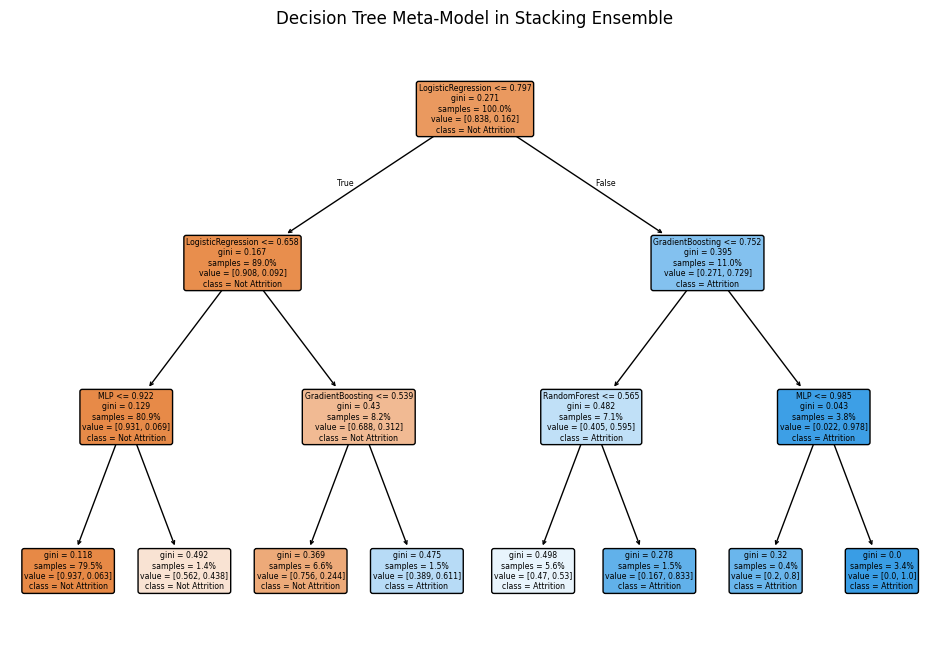

In [34]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

# Assume best_classifier_pipelines_random is your dictionary of best base pipelines after random search tuning.
# Create a list of (name, estimator) tuples for the stacking ensemble.
estimators = [(name, pipe) for name, pipe in best_classifier_pipelines_random.items()]

# Define the meta-model (final estimator) as a Decision Tree.
meta_model = DecisionTreeClassifier(random_state=42)

# Create the stacking classifier.
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,            # use 5-fold cross-validation to generate meta-features
    passthrough=False  # only use base predictions as input for the meta-model
)

# Define the hyperparameter grid for tuning the stacking ensemble.
# Here we tune the decision tree meta-model's parameters.
stacking_param_grid = {
    'final_estimator__max_depth': [None, 3, 5, 7],
    'final_estimator__min_samples_split': [2, 5, 10],
    'final_estimator__min_samples_leaf': [1, 2, 4],
    'passthrough': [False]  # fixed as False for simplicity
}

# Use RandomizedSearchCV for efficiency.
n_iter = 20  # adjust the number of iterations based on your computational budget

stacking_search = RandomizedSearchCV(
    stacking_clf,
    param_distributions=stacking_param_grid,
    n_iter=n_iter,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the stacking ensemble on the training data.
stacking_search.fit(X_train, y_train)

# Print the best hyperparameters and performance on the training set (via CV).
print("Best stacking parameters:")
print(stacking_search.best_params_)
print("Best stacking CV ROC AUC:", stacking_search.best_score_)

# Evaluate the best stacking model on the test set.
stacking_test_score = stacking_search.best_estimator_.score(X_test, y_test)
print("Test set score (accuracy) for best stacking ensemble:", stacking_test_score)

# Visualize the meta-model (decision tree).
# The meta-model is stored in stacking_search.best_estimator_.final_estimator_
meta_tree = stacking_search.best_estimator_.final_estimator_

plt.figure(figsize=(12, 8))
plot_tree(meta_tree, 
          filled=True, 
          feature_names=[name for name, _ in estimators],
          class_names=['Not Attrition', 'Attrition'], 
          rounded=True, 
          proportion=True)
plt.title("Decision Tree Meta-Model in Stacking Ensemble")
plt.show()


In [35]:
# Compute precision and recall on the test set.
from sklearn.metrics import precision_score, recall_score

y_pred = stacking_search.best_estimator_.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Test Precision:", precision)
print("Test Recall:", recall)

Test Precision: 0.5517241379310345
Test Recall: 0.3404255319148936
